# XAI Techniques for Random Forest\
### - Post-Hoc tecniques

In [79]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.model_selection import GridSearchCV

In [55]:
data = pd.read_csv("wnba_clean.csv")

In [56]:
data.head()

,shot_type,made_shot,shot_value,coordinate_x,coordinate_y,home_score,away_score,qtr,quarter_seconds_remaining,game_seconds_remaining,shot_group,distance,shot_group_encoded,shot_type_encoded
0,Jump Shot,False,0,-13,9,0,0,1,571,2371,Jump Shot,15.811388,3,29
1,Turnaround Bank Jump Shot,False,0,0,0,0,0,1,551,2351,Jump Shot,0.000000,3,8
2,Cutting Layup Shot,True,2,-21,2,0,2,1,538,2338,Layup,21.095023,1,25
3,Driving Layup Shot,True,2,0,0,2,2,1,524,2324,Layup,0.000000,1,14
4,Jump Shot,True,3,0,21,2,5,1,512,2312,Jump Shot,21.000000,3,29


In [57]:
X = data.drop(columns=["made_shot", "shot_type", "shot_value", "shot_group"])
y = data['made_shot']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Training the Random Forest

In [78]:
X_train

,coordinate_x,coordinate_y,home_score,away_score,qtr,quarter_seconds_remaining,game_seconds_remaining,distance,shot_group_encoded,shot_type_encoded
38877,-20,3,38,36,2,207,1407,20.223748,3,9
22111,-13,15,25,25,2,447,1647,19.849433,3,37
520,-8,0,80,104,4,158,158,8.000000,3,29
10084,-2,1,5,4,1,431,2231,2.236068,3,29
40933,0,2,32,36,2,39,1239,2.000000,1,35
...,...,...,...,...,...,...,...,...,...,...
6265,-25,15,23,27,2,452,1652,29.154759,6,53
11284,0,22,33,30,2,299,1499,22.000000,3,29
38158,-19,15,2,7,1,445,2245,24.207437,3,37
860,-25,15,78,76,4,72,72,29.154759,6,52


In [95]:
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20],    # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required in a leaf node
}

# Create the GridSearchCV object
model = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the model using grid search
model.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", model.best_params_)
print("Best Cross-Validation Score:", model.best_score_)


# Train the black-box model
#model = RandomForestClassifier(n_estimators= 150, min_samples_split= 10, min_samples_leaf= 4, random_state=42)
#model.fit(X_train, y_train)

# Generate predictions
y_black_box_train = model.predict(X_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation Score: 0.6695010087320731


In [96]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6691566265060241

Classification Report:
               precision    recall  f1-score   support

       False       0.63      0.76      0.69      6030
        True       0.72      0.58      0.64      6420

    accuracy                           0.67     12450
   macro avg       0.68      0.67      0.67     12450
weighted avg       0.68      0.67      0.67     12450



### Post Hoc XAI

#### Feature-based 

In [60]:
X_train.columns

Index(['coordinate_x', 'coordinate_y', 'home_score', 'away_score', 'qtr',
       'quarter_seconds_remaining', 'game_seconds_remaining', 'distance',
       'shot_group_encoded', 'shot_type_encoded'],
      dtype='object')

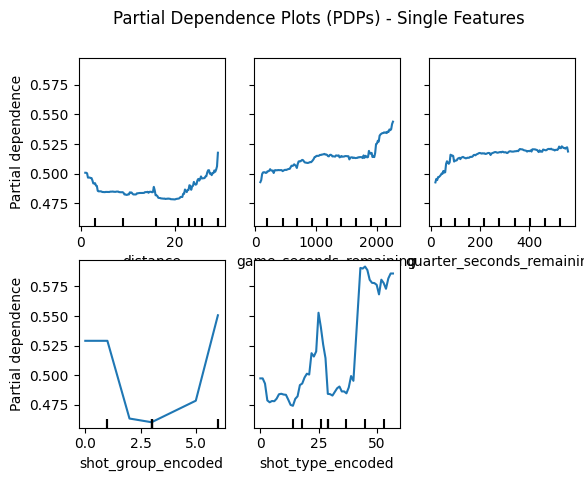

In [106]:
# Selected features for single-feature PDPs
selected_features = [7, 6, 5, 8, 9]

# Generate PDPs
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    selected_features,
    feature_names=[
        "coordinate_x", 
        "coordinate_y", 
        "home_score", 
        "away_score", 
        "qtr", 
        "quarter_seconds_remaining", 
        "game_seconds_remaining", 
        "distance", 
        "shot_group_encoded", 
        "shot_type_encoded"
    ],
    grid_resolution=150,
)

# Display the plot
plt.suptitle("Partial Dependence Plots (PDPs) - Single Features")

plt.show()

These PDP plots show highly complex relations in some features, such as the shot_type_encoded and game_seconds_remaining. These plots give interesting insights on how some features progressively present higher partial deoendence.

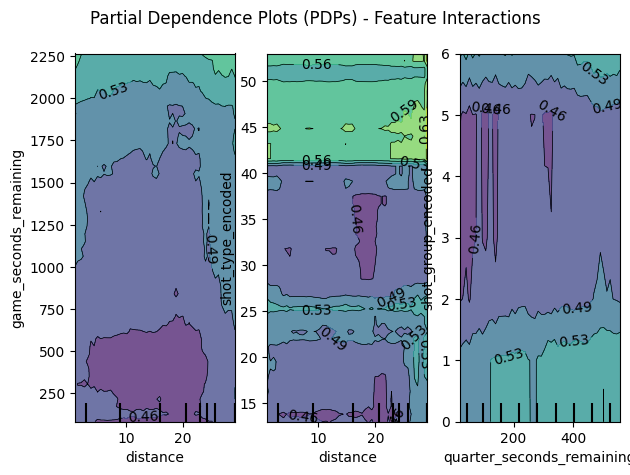

In [63]:
# Selected feature pairs for two-feature PDPs
interaction_features = [(7, 6), (7, 9), (5, 8)]  # distance vs game_seconds_remaining, etc.

# Generate 2D PDPs
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    interaction_features,
    feature_names=[
        "coordinate_x", 
        "coordinate_y", 
        "home_score", 
        "away_score", 
        "qtr", 
        "quarter_seconds_remaining", 
        "game_seconds_remaining", 
        "distance", 
        "shot_group_encoded", 
        "shot_type_encoded"
    ],
    grid_resolution=50,
)

# Display the plot
plt.suptitle("Partial Dependence Plots (PDPs) - Feature Interactions")
plt.tight_layout()
plt.show()


While sometimes messy, this type of plot can be full of good insights on the relations between two features, in this case, highlighting how interactions between distance, time remaining, and shot types influence the model's predictions, revealing non-linear patterns and regions of significant impact.

100%|===================| 58091/58094 [109:41<00:00]        

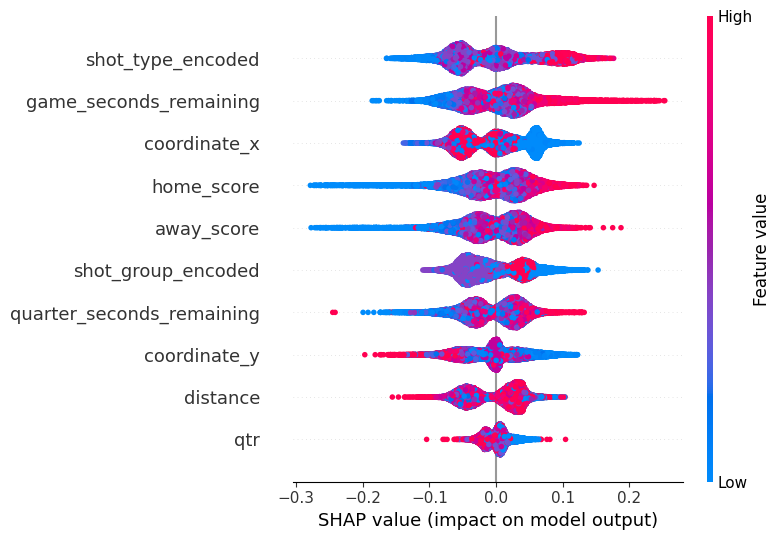

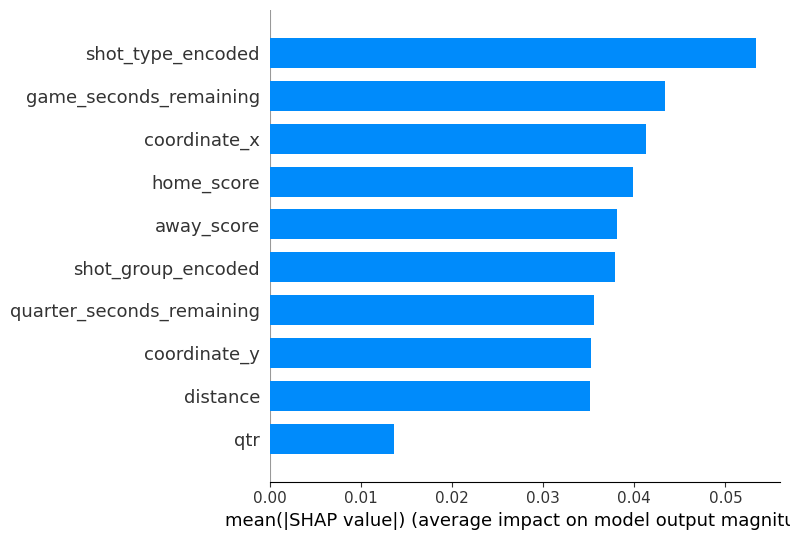

In [64]:
explainer = shap.Explainer(model, X_train)  # Initialize SHAP Explainer
shap_values = explainer(X_train)           

# Step 7: Visualize SHAP Values for Positive Class
shap_values_class1 = shap_values[..., 1] 

# SHAP Summary Plot
shap.summary_plot(shap_values_class1, X_train)

# SHAP Bar Plot
shap.summary_plot(shap_values_class1, X_train, plot_type="bar")


This SHAP analysis highlights the feature contributions to the Random Forest model's predictions:

The SHAP summary plot (top) shows how features like shot_type_encoded and game_seconds_remaining have the largest impact, with high values (red) generally increasing predictions.
The bar plot (bottom) confirms the overall importance of these features, with shot_type_encoded having the highest mean SHAP value, followed closely by game_seconds_remaining and coordinate_x.

This analysis emphasizes that shot characteristics and time-based features are key drivers of model decisions.

In [65]:
# Subset the training data (e.g., only the first 100 rows)
subset_X_train = X_train.iloc[:100]

In [66]:
feature_index = 7
feature_name = 'distance'

# Obtain ICE data
ice_results = partial_dependence(
    model, subset_X_train, [feature_index], grid_resolution=50, kind="individual"
)

In [67]:
feature_values = ice_results["grid_values"][0]  # Grid of feature values
ice_curves = ice_results["individual"][0]  # Individual curves (ICE)

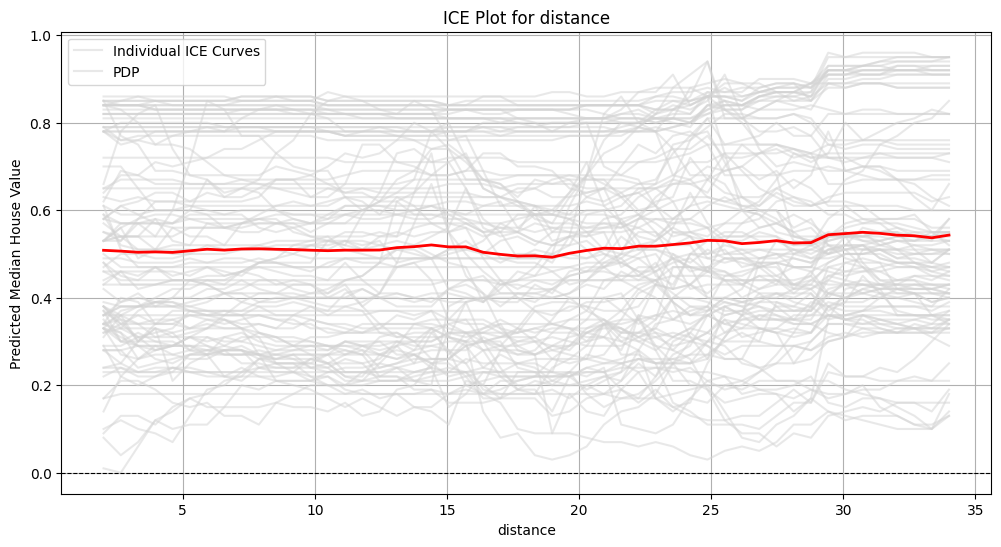

In [68]:
# Plot ICE Curves
plt.figure(figsize=(12, 6))

# Plot individual ICE curves
for ice_curve in ice_curves:
    plt.plot(feature_values, ice_curve, color="lightgray", alpha=0.5)
    
# Highlight the average curve (PDP)
average_curve = np.mean(ice_curves, axis=0)
plt.plot(feature_values, average_curve, color="red", label="PDP", linewidth=2)

# Add labels and title
plt.title(f"ICE Plot for {feature_name}")
plt.xlabel(feature_name)
plt.ylabel("Predicted Median House Value")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.legend(["Individual ICE Curves", "PDP"])
plt.grid()
plt.show()

Insights:

On average, as shown by the PDP, distance has a relatively flat effect on predictions, indicating minimal overall influence.
The variability in individual ICE curves suggests that distance impacts certain instances differently, highlighting potential interactions with other features that are not captured in the global trend.

This analysis helps identify where global and local patterns deviate, providing a nuanced view of feature behavior in the model.

#### Simplification-based: Surrogate Model

In [103]:
# Generate predictions
rf_preds = model.predict(X_train)  
rf_predtest = model.predict(X_test)

In [99]:
# Train the surrogate model (Decision Tree)
surrogate_model = DecisionTreeClassifier(max_depth=4, random_state=42)
surrogate_model.fit(X_train, rf_preds)  # Train on RF predictions

# Evaluate the surrogate model
# Agreement Rate
surrogate_preds = surrogate_model.predict(X_train)
agreement_rate = accuracy_score(rf_preds, surrogate_preds)

# Print Results
print(f"Agreement Rate: {agreement_rate:.4f}")

Agreement Rate: 0.6607


In [104]:
# Model evaluation
y_pred_sur = surrogate_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_sur))
print("\nClassification Report:\n", classification_report(y_test, y_pred_sur))


# Evaluate fidelity
y_surrogate_pred = surrogate_model.predict(X_test)
fidelity = accuracy_score(rf_predtest, y_surrogate_pred)
print(f"Surrogate Model Fidelity: {fidelity:.2f}")

Accuracy: 0.6636144578313253

Classification Report:
               precision    recall  f1-score   support

       False       0.64      0.71      0.67      6030
        True       0.70      0.62      0.65      6420

    accuracy                           0.66     12450
   macro avg       0.67      0.67      0.66     12450
weighted avg       0.67      0.66      0.66     12450

Surrogate Model Fidelity: 0.94


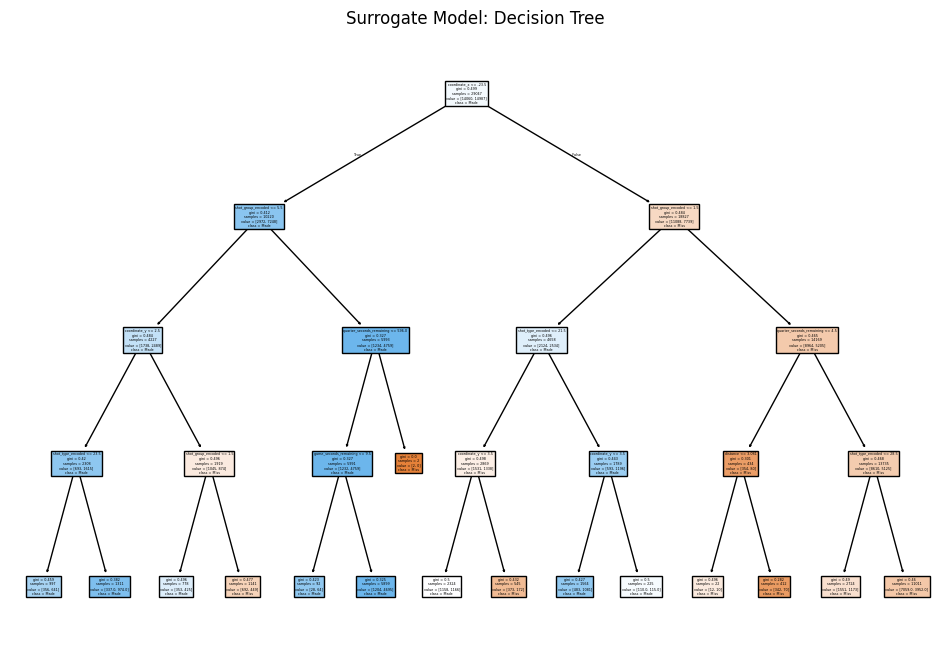

In [101]:
# Visualize the surrogate model
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 8))
plot_tree(surrogate_model, feature_names=X.columns, filled=True, class_names=['Miss', 'Made'])
plt.title("Surrogate Model: Decision Tree")
plt.show()

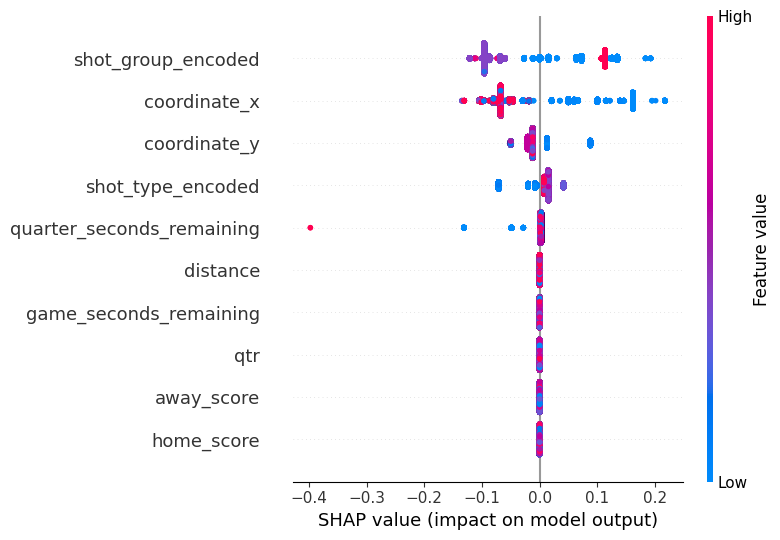

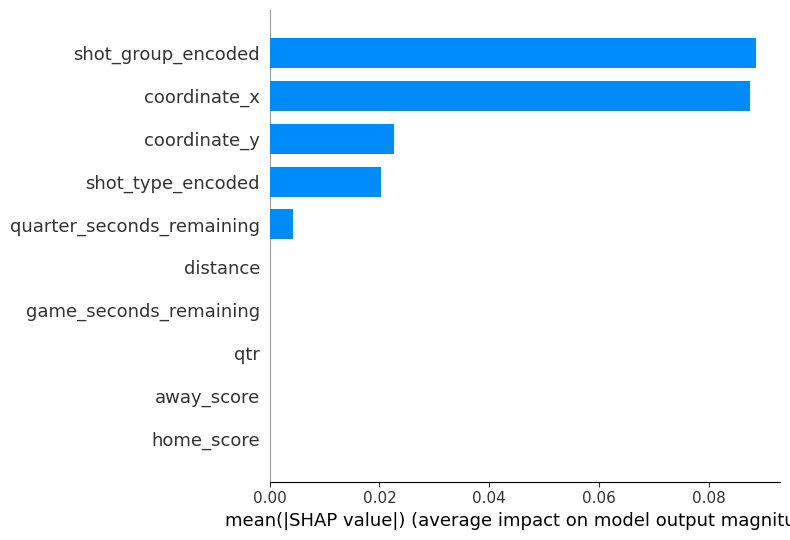

In [73]:
#Explain Predictions with SHAP for surrogate model
explainer = shap.Explainer(surrogate_model, X_train)  # Initialize SHAP Explainer
shap_values = explainer(X_train)              # Compute SHAP values

# Visualize SHAP Values for Positive Class (class 1)
shap_values_class1 = shap_values[..., 1]  # Select SHAP values for class 1 (if binary classification)

# SHAP Summary Plot
shap.summary_plot(shap_values_class1, X_train)

# SHAP Bar Plot
shap.summary_plot(shap_values_class1, X_train, plot_type="bar")


As this is a simpler model, it is interesting to see that even though it mimics the predictions, the features that present most importance are very different, because a simpler model can't capture the more complex relations between features, resulting in a completely different SHAP analysis.